In [2]:
import os
import re
import glob
import numpy as np
import pandas as pd
import nltk

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter

ps = PorterStemmer()

In [4]:
ham_folder = 'enron1/ham'
print(f"Current working directory: {os.getcwd()}")

processed_ham = []
ham_files = os.listdir(ham_folder)
ham_files = [f for f in ham_files if f.endswith('.txt')]

if not ham_files:
    print("No .txt files found in the ham folder.")
else:
    print(f"Found {len(ham_files)} ham files.")

print("Processing ham emails...")
for index, txt_file in enumerate(ham_files):
    file_path = os.path.join(ham_folder, txt_file)
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
        content = file.readlines()
        words = []
        #Process lines, tokenize, filter and stem each line
        for line in content:
            tokens = word_tokenize(line)
            #Remove any sequence of digits d+ with ""
            filtered_tokens = [re.sub(r'\d+', '', w) for w in tokens if re.sub(r'\d+', '', w)]
            stemmed_words = [ps.stem(w) for w in filtered_tokens if w]
            if index < 2:
                print(f"Filtered tokens (numbers removed): {filtered_tokens[:5]}")  # Print first 5 filtered tokens
                print(f"Stemmed tokens: {stemmed_words[:5]}") # Print first 5 stemmed tokes
            words += stemmed_words
        email = Counter(words) #Count word freq for vectors
        processed_ham.append(email)
print("Ham emails processed")
print(f"Total processed ham emails: {len(processed_ham)}")

Current working directory: /Users/alexbanoun/ML/SpamModel
Found 3672 ham files.
Processing ham emails...
Filtered tokens (numbers removed): ['Subject', ':', 'ena', 'sales', 'on']
Stemmed tokens: ['subject', ':', 'ena', 'sale', 'on']
Filtered tokens (numbers removed): ['just', 'to', 'update', 'you', 'on']
Stemmed tokens: ['just', 'to', 'updat', 'you', 'on']
Filtered tokens (numbers removed): ['based', 'on', 'a', 'new', 'report']
Stemmed tokens: ['base', 'on', 'a', 'new', 'report']
Filtered tokens (numbers removed): ['with', 'the', 'following', 'counterparties', 'as']
Stemmed tokens: ['with', 'the', 'follow', 'counterparti', 'as']
Filtered tokens (numbers removed): ['of', 'hpl', "'", 's', 'pipe']
Stemmed tokens: ['of', 'hpl', "'", 's', 'pipe']
Filtered tokens (numbers removed): ['altrade', 'transaction', ',', 'l', '.']
Stemmed tokens: ['altrad', 'transact', ',', 'l', '.']
Filtered tokens (numbers removed): ['brazoria', ',', 'city', 'of', 'panther']
Stemmed tokens: ['brazoria', ',', 'citi

In [6]:
spam_folder = 'enron1/spam'
print(f"Current working directory: {os.getcwd()}")

processed_spam = []
spam_files = os.listdir(spam_folder)
spam_files = [f for f in spam_files if f.endswith('.txt')]

if not spam_files:
    print("No .txt files found in the spam folder.")
else:
    print(f"Found {len(spam_files)} spam files.")

print("Processing spam emails...")
for txt_file in spam_files:
    file_path = os.path.join(spam_folder, txt_file)
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
        content = file.readlines()
        words = []
        #Process lines, tokenize, filter and stem each line
        for line in content:
            tokens = word_tokenize(line)
            #Remove any sequence of digits d+ with ""
            filtered_tokens = [re.sub(r'\d+', '', w) for w in tokens if re.sub(r'\d+', '', w)]
            stemmed_words = [ps.stem(w) for w in filtered_tokens if w]
            words += stemmed_words
        email = Counter(words)
        processed_spam.append(email)
print("Spam emails processed")
print(f"Total processed ham emails: {len(processed_spam)}")

Current working directory: /Users/alexbanoun/ML/SpamModel
Found 1500 spam files.
Processing spam emails...
Spam emails processed
Total processed ham emails: 1500


In [10]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
processed_all = processed_ham + processed_spam
#Vectorize data
X = vec.fit_transform(processed_all).toarray()
print(f"Shape of the feature matrix X: {X.shape}")
#Label data
Y = np.concatenate([np.zeros(len(processed_ham)),np.ones(len(processed_spam))])
Y = np.array(Y, dtype=np.int64)

print("Sample feature vector (first email):", X[0])
print("Sample label (first email):", Y[0])
print("Sample feature vector (last email):", X[-1])
print("Sample label (last email):", Y[-1])

Shape of the feature matrix X: (5172, 38053)
Sample feature vector (first email): [0. 0. 0. ... 0. 0. 0.]
Sample label (first email): 0
Sample feature vector (last email): [0. 0. 0. ... 0. 0. 0.]
Sample label (last email): 1


Now for the different models. We will test multiple models to try to increase performance:

- Naive Bayes classifier
- Nearest Neighbor NN

In [114]:
class NaiveBayes:
    def __init__(self, data, labels, split=0.8, cutoff=0.00000001):
        self.split = split 
        
        #Randomization of Data
        indices = np.random.permutation(data.shape[0])
        data = data[indices]
        labels = labels[indices]

        #Splitting data into Training and Testing Sets
        self.X = data[0:int(data.shape[0] * self.split)]
        self.Y = labels[0:int(data.shape[0] * self.split)]
        self.test_X = data[int(data.shape[0] * self.split):]
        self.test_Y = labels[int(data.shape[0] * self.split):]

        # Identify features with variance above the cutoff
        self.CUTOFF = cutoff
        self.feature_indices = self._identify_features_above_cutoff()
        
        #Filter to retain only said features and split
        self.X = self.X[:, self.feature_indices]
        self.test_X = self.test_X[:, self.feature_indices]

        # Separate data by class after feature selection 
        # sep[0] is data with label 0. sep[1] with label 1
        self.sep = [self.X[self.Y == i] for i in range(2)]
        
        print("Final test data shape:", self.test_X.shape)
        for i in range(2):
            print(f"Final training data shape for label {i}:", self.sep[i].shape)
        
        #Calculate Priors, Means, StD Deviations
        self.means = []
        self.vars = []
        self.priors = []  #Compute priors
        for i in range(2):
            self.means.append(np.average(self.sep[i],axis=0))
            self.vars.append(np.var(self.sep[i],axis=0))
            self.priors.append(len(self.sep[i]) / len(data))
        print("Means calculated for each class.")
        print("Variances calculated for each class.")
        print("Priors calculated for each class.")
        
        self.normals = [scipy.stats.norm(self.means[i], self.vars[i]) for i in range(2)]
        print("Parameters computed.")
        print("Initialization complete.")

    def _identify_features_above_cutoff(self):
        # Identify features with variance above the cutoff
        variances = [np.var(self.X[self.Y == i], axis=0) for i in range(2)]
        indices = [np.where(variances[i] > self.CUTOFF)[0] for i in range(2)]
        selected_indices = np.intersect1d(indices[0], indices[1])
        print(f"Selected feature indices: {selected_indices}")
        return selected_indices 
                        
    def normal(self, x, label): #Compute Gaussian PDF Value
        return np.log(self.normals[label].pdf(x)).sum()
        print(f"Log PDF for label {label}: {log_pdf}")

    def likelihood(self, x, label): #Compute log likelihood of multivariate
        #Since we are taking the log we can add instead of multiply P(x|y)P(y)
        return self.normal(x, label) + np.log(self.priors[label])

    def predict(self, x):
        vals = np.zeros(2)
        for i in range(2):
            vals[i] = self.likelihood(x, i)
        return np.argmax(vals)

    def evaluate(self):
        n_train = self.X.shape[0]
        n_test = self.test_X.shape[0]
        print("Evaluating model over size %d training dataset and size %d test set" % (n_train, n_test))
        #Evaluate on training data
        count_train = 0
        for i in range(n_train):
            prediction = self.predict(self.X[i])
            if prediction == self.Y[i]:
                count_train += 1
        print("This model is %d percent accurate on %d training datapoints!" % (count_train / n_train * 100, n_train))
        #Evaluate on test data
        count_test = 0
        for i in range(n_test):
            prediction = self.predict(self.test_X[i])
            if prediction == self.test_Y[i]:
                count_test += 1
        print("This model is %d percent accurate on %d testing datapoints!" % (count_test / n_test * 100, n_test))
        return count_train / n_train,  count_test / n_test



In [116]:
#Testing Naive Bayes Classifier
split = [0.3, 0.5, 0.7, 0.9]
accuracy = []
for i in split:
    nb = NaiveBayes(X, Y, split=i)
    accuracy.append(nb.evaluate())

Selected feature indices: [   11    12    13 ... 38049 38050 38051]
Final test data shape: (3621, 3131)
Final training data shape for label 0: (1113, 3131)
Final training data shape for label 1: (438, 3131)
Means calculated for each class.
Variances calculated for each class.
Priors calculated for each class.
Parameters computed.
Initialization complete.
Evaluating model over size 1551 training dataset and size 3621 test set


/var/folders/73/qzzrqcbs5mzg_n0kvzrcz53m0000gn/T/ipykernel_91785/1315922860.py:57: RuntimeWarning: divide by zero encountered in log
  return np.log(self.normals[label].pdf(x)).sum()


This model is 72 percent accurate on 1551 training datapoints!
This model is 71 percent accurate on 3621 testing datapoints!
Selected feature indices: [   11    12    13 ... 38050 38051 38052]
Final test data shape: (2586, 4469)
Final training data shape for label 0: (1818, 4469)
Final training data shape for label 1: (768, 4469)
Means calculated for each class.
Variances calculated for each class.
Priors calculated for each class.
Parameters computed.
Initialization complete.
Evaluating model over size 2586 training dataset and size 2586 test set
This model is 71 percent accurate on 2586 training datapoints!
This model is 73 percent accurate on 2586 testing datapoints!
Selected feature indices: [    6    11    12 ... 38050 38051 38052]
Final test data shape: (1552, 5031)
Final training data shape for label 0: (2576, 5031)
Final training data shape for label 1: (1044, 5031)
Means calculated for each class.
Variances calculated for each class.
Priors calculated for each class.
Parameter

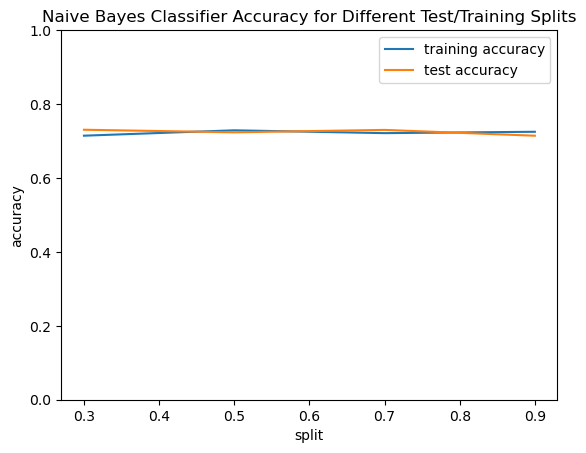

In [90]:
import matplotlib.pyplot as plt
plt.plot(split, np.array(accuracy)[:,0],label="training accuracy")
plt.plot(split, np.array(accuracy)[:,1],label="test accuracy")
plt.xlabel("split")
plt.ylabel("accuracy")
plt.title("Naive Bayes Classifier Accuracy for Different Test/Training Splits")
plt.ylim([0,1])
plt.legend()
plt.show()

In [14]:
#k-NN Classifier
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt

class KNNClassifier:
    def __init__(self, data, labels, split=0.8):
        print('Importing Data')
        self.split = split

        #Randomizing the data and labes
        indices = np.random.permutation(data.shape[0])
        data = data[indices]
        labels = labels[indices]

        #Splitting data into training and testing sets
        self.X = data[0:int(data.shape[0] * self.split)]
        self.Y = labels[0:int(data.shape[0] * self.split)]
        self.test_X = data[int(data.shape[0] * self.split):]
        self.test_Y = labels[int(data.shape[0] * self.split):]
        
        # Printing shapes of the splits
        print(f"Training data shape: {self.X.shape}, Training labels shape: {self.Y.shape}")
        print(f"Test data shape: {self.test_X.shape}, Test labels shape: {self.test_Y.shape}")

    def predict(self, x, k, norm = "L2"):
        #Calculate desired norm
        if norm == "L1": #L1 Norm, Manhattan Distance
            distances = np.abs(self.X - x).sum(axis=1)
        elif norm == "L2": #L2 Norm, Euclidean Distance
            distances = ((self.X - x)**2).sum(axis=1)
        elif norm == "Linfty": #Linfty norm
            distances = np.max(np.abs(self.X - x), axis=1)
        else:
            raise ValueError("Unsupported norm type. Use 'L1', 'L2', or 'Linfty'.")
        #Find k nearest neighbors
        nn_indices = np.argpartition(distances, k)[:k]
        nn_labels = self.Y[nn_indices]
        # Count the occurrences of each label among the nearest neighbors and return
        label_counts = np.bincount(np.asarray(nn_labels, dtype=np.int64))
        prediction = np.argmax(label_counts)
        return prediction
    
    def evaluate(self, n=None, k=5, norm="L2"):
        if n is None:
            n = self.test_X.shape[0]
        print("Testing %d nearest neighbor model over %d email test set" % (k,n))
        count = 0
        for i in range(n):
            prediction = self.predict(self.test_X[i], k, norm=norm)
            if prediction == self.test_Y[i]:
                count += 1
        print("This model is %d percent accurate!" % (count / n * 100))
        return count / n

In [16]:
#TEST NEAREST NEIGHBOR
split = [0.3, 0.5, 0.7, 0.9]
ks = [1, 2, 5, 10]
accuracy = []
for k in ks:
    k_accuracy = []
    for i in split:
        classifier = KNNClassifier(X, Y, split=i)
        k_accuracy.append(classifier.evaluate(k=k, norm="L2", n = 100))
    accuracy.append(k_accuracy)

Importing Data
Training data shape: (1551, 38053), Training labels shape: (1551,)
Test data shape: (3621, 38053), Test labels shape: (3621,)
Testing 1 nearest neighbor model over 100 email test set
This model is 90 percent accurate!
Importing Data
Training data shape: (2586, 38053), Training labels shape: (2586,)
Test data shape: (2586, 38053), Test labels shape: (2586,)
Testing 1 nearest neighbor model over 100 email test set
This model is 87 percent accurate!
Importing Data
Training data shape: (3620, 38053), Training labels shape: (3620,)
Test data shape: (1552, 38053), Test labels shape: (1552,)
Testing 1 nearest neighbor model over 100 email test set
This model is 89 percent accurate!
Importing Data
Training data shape: (4654, 38053), Training labels shape: (4654,)
Test data shape: (518, 38053), Test labels shape: (518,)
Testing 1 nearest neighbor model over 100 email test set
This model is 92 percent accurate!
Importing Data
Training data shape: (1551, 38053), Training labels sha

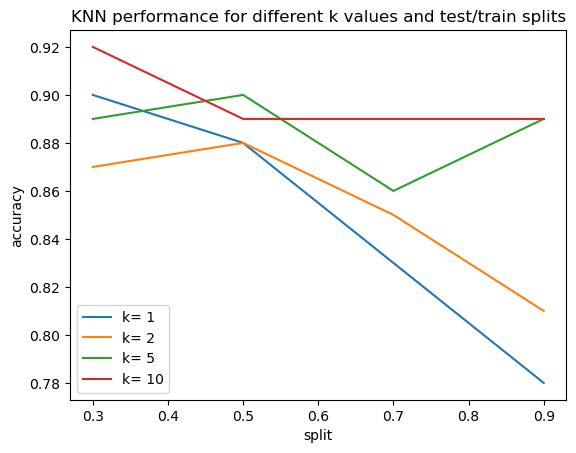

In [18]:
import matplotlib.pyplot as plt
for i in range(len(ks)):
    plt.plot(split, np.array(accuracy)[:, i], label="k= {}".format(ks[i]))
plt.xlabel("split")
plt.ylabel("accuracy")
plt.title("KNN performance for different k values and test/train splits")
plt.legend()
plt.show()

In [20]:
#Sklearn for comparison
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [22]:
split = [0.3, 0.5, 0.7, 0.9]
ks = [1, 2, 5, 10]
accuracy = []
for k in ks:
    k_accuracy = []
    for i in split:
        print(i, k)
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1-i, random_state=42)
        X_train, X_test, Y_train, Y_test = X_train[0:1000], X_test[0:100], Y_train[0:1000], Y_test[0:100]
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, Y_train)
        k_accuracy.append(knn.score(X_test, Y_test))
    accuracy.append(k_accuracy)

0.3 1
0.5 1
0.7 1
0.9 1
0.3 2
0.5 2
0.7 2
0.9 2
0.3 5
0.5 5
0.7 5
0.9 5
0.3 10
0.5 10
0.7 10
0.9 10


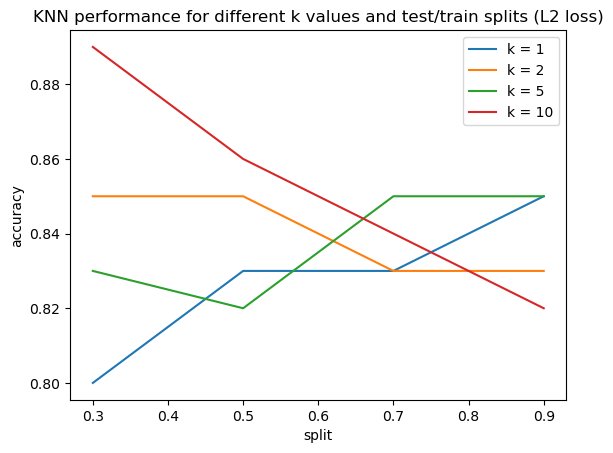

In [26]:
import matplotlib.pyplot as plt
for i in range(len(ks)):
    plt.plot(split, np.array(accuracy)[:, i], label="k = {}".format(ks[i]))
plt.xlabel("split")
plt.ylabel("accuracy")
plt.title("KNN performance for different k values and test/train splits (L2 loss)")
plt.legend()
plt.show()